In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm.notebook import tqdm
from tqdm import tqdm

In [2]:
fps = 120
dataframes = {}

folder_path = 'videos/all_videos'
file_names = os.listdir(folder_path)

for video_name in file_names:
    cap = cv2.VideoCapture('videos/all_videos/' + video_name) # vervang dit path naar het path van je eigen video
    cap_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    cap_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # The following code is modified code written by Sten den Hartog!
    ###################################################################

    # Set up parameters for ShiTomasi corner detection
    feature_params = dict(maxCorners=1, qualityLevel=0.3, minDistance=7, blockSize=7)

    # Set up parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Read the first frame
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    # Select ROI for tracking
    bbox = cv2.selectROI(old_frame, False)
    cv2.destroyAllWindows()
    x, y, w, h = bbox

    # if you want to manually set the ROI, comment the lines above and paste the ROI below
    # x, y, w, h = 0, 0, 0, 0

    roi_mask = np.zeros_like(old_gray)
    roi_mask[y:y+h, x:x+w] = 255

    # Detect initial points in ROI
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=roi_mask, **feature_params)

    # Check if any points were detected
    if p0 is None:
        print("Unable to determine tracking features, please adjust bounding box.")
        cap.release()  # Release the video capture object
        sys.exit()  # Exit the program

    # List to store the displacement of points
    displacements = []

    output = cv2.VideoWriter( 
            'C:/Users/Gebruiker/Videos/roi_tracked_output.avi' , cv2.VideoWriter_fourcc(*'XVID'), fps, (cap_width, cap_height))

    # Draw initial tracking point
    highlight_color = (0, 255, 0)  # Green
    circle_radius = 5              
    circle_thickness = -1          # -1 to fill the circle

    frame_circle = cv2.circle(old_frame, p0.astype(int).ravel(), circle_radius, highlight_color, circle_thickness)
    output.write(frame_circle)

    # Process video
    iteration = 0
    with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), desc="Tracking") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Calculate optical flow
            p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

            # Ensure optical flow was successful
            if p1 is not None and len(p1) > 0:
                # Select good points
                good_new = p1[st == 1]
                good_old = p0[st == 1]

                # Store points' displacements
                for i, (new, old) in enumerate(zip(good_new, good_old)):
                    a, b = new.ravel()
                    c, d = old.ravel()
                    displacements.append({'iteration': iteration, 'time': pbar.n / fps, 'id': i, 'x': a, 'y': b, 'dx': a - c, 'dy': b - d})

                # Update the previous frame and points
                old_gray = frame_gray.copy()
                p0 = good_new.reshape(-1, 1, 2)
            else:
                print("Unable to determine tracking features, please adjust bounding box.")
                break  # Break out of the loop if tracking fails
            
            frame_circle = cv2.circle(frame, good_new.astype(int).ravel(), circle_radius, highlight_color, circle_thickness)
            output.write(frame_circle)

            pbar.update(1)
            iteration += 1

    cap.release()
    output.release()
    ###################################################################

    # Convert the list of displacements to a DataFrame
    df_displacements = pd.DataFrame(displacements)
    dataframes[video_name] = df_displacements

Tracking: 925it [00:03, 276.80it/s]
Tracking: 923it [00:03, 285.55it/s]
Tracking: 929it [00:03, 278.93it/s]
Tracking: 934it [00:03, 282.32it/s]
Tracking: 918it [00:03, 285.48it/s]
Tracking: 917it [00:03, 283.24it/s]
Tracking: 911it [00:03, 279.35it/s]
Tracking: 917it [00:03, 280.69it/s]
Tracking: 921it [00:03, 281.78it/s]
Tracking: 917it [00:03, 280.99it/s]
Tracking: 910it [00:03, 279.80it/s]
Tracking: 935it [00:03, 278.13it/s]
Tracking: 940it [00:03, 257.30it/s]
Tracking: 929it [00:03, 280.80it/s]
Tracking: 923it [00:03, 280.26it/s]
Tracking: 920it [00:04, 206.36it/s]
Tracking: 939it [00:03, 256.72it/s]
Tracking: 909it [00:03, 246.45it/s]
Tracking: 917it [00:03, 259.30it/s]
Tracking: 937it [00:03, 257.71it/s]
Tracking: 917it [00:03, 281.22it/s]
Tracking: 919it [00:03, 285.33it/s]
Tracking: 938it [00:03, 288.33it/s]
Tracking: 933it [00:03, 280.58it/s]
Tracking: 936it [00:03, 282.54it/s]
Tracking: 916it [00:03, 274.33it/s]
Tracking: 933it [00:03, 281.42it/s]
Tracking: 914it [00:03, 275.

In [3]:
# create a folder for the CSVs if it doesn't already exist
output_folder = 'exported_csvs'
os.makedirs(output_folder, exist_ok=True)

# save each DataFrame to a CSV file
for video_name, df in dataframes.items():
    csv_filename = os.path.join(output_folder, f"{video_name}.csv")
    df.to_csv(csv_filename, index=False) 
    print(f"Saved: {csv_filename}")

Saved: exported_csvs\koel_640_480_120fps_take1.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take10_deuropen.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take1_deuropen.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take2.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take2_deuropen.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take3.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take3_deuropen.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take4.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take4_deuropen.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take5.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take5_deuropen.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take6_deuropen.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take7_deuropen.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take8_deuropen.h264.csv
Saved: exported_csvs\koel_640_480_120fps_take9_deuropen.h264.csv
Saved: exported_csvs\koel_take1.h264.csv
Saved: exported_csvs\koel_ta

In [5]:
# load dataframes from csv files
dataframes = {}
output_folder = 'exported_csvs'

# list all CSV files in the output folder
csv_files = [f for f in os.listdir(output_folder) if f.endswith('.csv')]

# load each CSV file into the dictionary
for csv_file in csv_files:
    video_name = os.path.splitext(csv_file)[0]  # Get the video name without the extension
    csv_path = os.path.join(output_folder, csv_file)
    dataframes[video_name] = pd.read_csv(csv_path)
    print(f"Loaded: {csv_path}")


Loaded: exported_csvs\koel_640_480_120fps_take1.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take10_deuropen.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take1_deuropen.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take2.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take2_deuropen.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take3.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take3_deuropen.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take4.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take4_deuropen.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take5.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take5_deuropen.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take6_deuropen.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take7_deuropen.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take8_deuropen.h264.csv
Loaded: exported_csvs\koel_640_480_120fps_take9_deuropen.h264.csv
Loaded: exported_csvs\koel_take1.h264.csv
Loaded: expo

In [6]:
df_1sec = dataframes['koel_640_480_120fps_take1.h264'].head(100)
df_1sec

,iteration,time,id,x,y,dx,dy
0,0,0.000000,0,307.21567,271.32297,0.215668,1.322968
1,1,0.008333,0,307.21870,271.16130,0.003021,-0.161682
2,2,0.016667,0,306.95374,269.77896,-0.264954,-1.382324
3,3,0.025000,0,306.78735,270.80295,-0.166382,1.023987
4,4,0.033333,0,306.64930,271.52927,-0.138062,0.726318
...,...,...,...,...,...,...,...
95,95,0.791667,0,306.88788,269.94630,0.287842,-1.607300
96,96,0.800000,0,307.05637,271.40564,0.168488,1.459351
97,97,0.808333,0,307.02164,271.20276,-0.034729,-0.202881
98,98,0.816667,0,306.88440,269.93164,-0.137238,-1.271118


Test extraction of dominant frequency

In [7]:
# Compute the FFT of the y-displacement
time = df_1sec['time'].values
y = df_1sec['dy'].values

# Time step
dt = np.mean(np.diff(time))
# Sampling frequency
fs = 1 / dt  

fft_result = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(y), d=dt)

# Only keep positive frequencies
positive_freqs = frequencies[frequencies >= 0]
amplitude_spectrum = np.abs(fft_result[frequencies >= 0])
dominant_frequency = positive_freqs[np.argmax(amplitude_spectrum)]
dominant_frequency

43.199999999999996

In [12]:
# plot the frequency spectrum for each video in the same plot
fig = go.Figure()

for video_name, df_displacements in dataframes.items():
    # skip deuropen videos
    if 'deuropen' in video_name:
        continue
    # Compute the FFT of the y-displacement
    time = df_displacements['time'].values
    y = df_displacements['dy'].values

    # Time step
    dt = np.mean(np.diff(time))
    # Sampling frequency
    fs = 1 / dt  

    fft_result = np.fft.fft(y)
    frequencies = np.fft.fftfreq(len(y), d=dt)

    # Only keep positive frequencies
    positive_freqs = frequencies[frequencies >= 0]
    amplitude_spectrum = np.abs(fft_result[frequencies >= 0])

    color = 'red' if 'koel' in video_name else 'blue'
    fig.add_trace(
        go.Scatter(
            x=positive_freqs,
            y=amplitude_spectrum,
            mode='lines',
            name=video_name,
            line=dict(color=color)
        )
    )

fig.update_layout(
    title='Frequency Spectrum for All Videos',
    xaxis_title='Frequency (Hz)',
    yaxis_title='Amplitude',
    legend_title='Videos'
)

fig.show()

In [13]:
# plot the cooling mode (koel or vries) vs the dominant frequency of the frequency spectrum
fig = go.Figure()

cooling_modes = []
dominant_frequencies = []
for video_name, df_displacements in dataframes.items():
    # skip deuropen videos 
    if 'deuropen' in video_name:
        continue
    # Compute the FFT of the y-displacement
    time = df_displacements['time'].values
    y = df_displacements['dy'].values

    # Time step
    dt = np.mean(np.diff(time))
    # Sampling frequency
    fs = 1 / dt  

    fft_result = np.fft.fft(y)
    frequencies = np.fft.fftfreq(len(y), d=dt)

    # Only keep positive frequencies
    positive_freqs = frequencies[frequencies >= 0]
    amplitude_spectrum = np.abs(fft_result[frequencies >= 0])

    # find cooling mode from video_name
    cooling_mode = 'koel' if 'koel' in video_name else 'vries'
    cooling_modes.append(cooling_mode)
    # find the dominant frequency
    dominant_frequency = positive_freqs[np.argmax(amplitude_spectrum)]
    dominant_frequencies.append(dominant_frequency)

# plot
plot_df = pd.DataFrame({
'Cooling Mode': cooling_modes,
'Dominant Frequency (Hz)': dominant_frequencies
})

fig = px.scatter(
    plot_df,
    x='Dominant Frequency (Hz)',
    y='Cooling Mode',
    color='Cooling Mode',
    title='Cooling Mode vs. Dominant Frequency',
    labels={'Cooling Mode': 'Cooling Mode', 'Dominant Frequency (Hz)': 'Dominant Frequency (Hz)'},
    color_discrete_map={'koel': 'red', 'vries': 'blue'}
)

fig.show()


In [14]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

dominant_frequencies = np.array(dominant_frequencies).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(dominant_frequencies, cooling_modes, test_size=0.2, random_state=42)

dtree_classifier = DecisionTreeClassifier(random_state=42)
dtree_classifier.fit(X_train, y_train)

y_pred = dtree_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

        koel       1.00      1.00      1.00         2
       vries       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



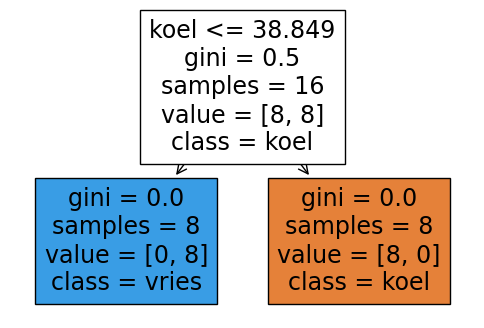

In [15]:
plt.figure(figsize=(6, 4))
plot_tree(dtree_classifier, feature_names=cooling_modes, class_names=dtree_classifier.classes_, filled=True)
plt.show()

Analysis with deuropen videos

In [23]:
# plot the frequency spectrum for koel videos (normal vs deuropen) in the same plot
fig = go.Figure()

for video_name, df_displacements in dataframes.items():
    # skip vries videos
    if 'vries' in video_name:
        continue
    # Compute the FFT of the y-displacement
    time = df_displacements['time'].values
    y = df_displacements['dy'].values

    # Time step
    dt = np.mean(np.diff(time))
    # Sampling frequency
    fs = 1 / dt  

    fft_result = np.fft.fft(y)
    frequencies = np.fft.fftfreq(len(y), d=dt)

    # Only keep positive frequencies
    positive_freqs = frequencies[frequencies >= 0]
    amplitude_spectrum = np.abs(fft_result[frequencies >= 0])

    color = 'red' if 'deuropen' in video_name else 'blue'
    fig.add_trace(
        go.Scatter(
            x=positive_freqs,
            y=amplitude_spectrum,
            mode='lines',
            name=video_name,
            line=dict(color=color)
        )
    )

fig.update_layout(
    title='Frequency Spectrum for koel Videos (deuropen vs normaal)',
    xaxis_title='Frequency (Hz)',
    yaxis_title='Amplitude',
    legend_title='Videos'
)

fig.show()

In [24]:
# plot the cooling mode (koel or vries) vs the dominant frequency of the frequency spectrum
fig = go.Figure()

cooling_modes = []
dominant_frequencies = []
for video_name, df_displacements in dataframes.items():
    # skip vries videos 
    if 'vries' in video_name:
        continue
    # Compute the FFT of the y-displacement
    time = df_displacements['time'].values
    y = df_displacements['dy'].values

    # Time step
    dt = np.mean(np.diff(time))
    # Sampling frequency
    fs = 1 / dt  

    fft_result = np.fft.fft(y)
    frequencies = np.fft.fftfreq(len(y), d=dt)

    # Only keep positive frequencies
    positive_freqs = frequencies[frequencies >= 0]
    amplitude_spectrum = np.abs(fft_result[frequencies >= 0])

    # find cooling mode from video_name
    cooling_mode = 'deuropen' if 'deuropen' in video_name else 'normaal'
    cooling_modes.append(cooling_mode)
    # find the dominant frequency
    dominant_frequency = positive_freqs[np.argmax(amplitude_spectrum)]
    dominant_frequencies.append(dominant_frequency)

# plot
plot_df = pd.DataFrame({
'Cooling Mode': cooling_modes,
'Dominant Frequency (Hz)': dominant_frequencies
})

fig = px.scatter(
    plot_df,
    x='Dominant Frequency (Hz)',
    y='Cooling Mode',
    color='Cooling Mode',
    title='Deuropen vs. Dominant Frequency of koel videos',
    labels={'Cooling Mode': 'Cooling Mode', 'Dominant Frequency (Hz)': 'Dominant Frequency (Hz)'},
    color_discrete_map={'deuropen': 'red', 'vries': 'blue'}
)

fig.show()


In [21]:
# create a dataframe where each row is a video and the columns contain amplitude per frequency

for video_name, df_displacements in dataframes.items():
    frequencies = []
    amplitudes = []

    # skip vries videos
    if 'vries' in video_name:
        continue
    # Compute the FFT of the y-displacement
    time = df_displacements['time'].values
    y = df_displacements['dy'].values

    # Time step
    dt = np.mean(np.diff(time))
    # Sampling frequency
    fs = 1 / dt  

    fft_result = np.fft.fft(y)
    frequencies = np.fft.fftfreq(len(y), d=dt)

    # Only keep positive frequencies
    positive_freqs = frequencies[frequencies >= 0]
    amplitude_spectrum = np.abs(fft_result[frequencies >= 0])
    print(positive_freqs)
    

[ 0.          0.12972973  0.25945946  0.38918919  0.51891892  0.64864865
  0.77837838  0.90810811  1.03783784  1.16756757  1.2972973   1.42702703
  1.55675676  1.68648649  1.81621622  1.94594595  2.07567568  2.20540541
  2.33513514  2.46486486  2.59459459  2.72432432  2.85405405  2.98378378
  3.11351351  3.24324324  3.37297297  3.5027027   3.63243243  3.76216216
  3.89189189  4.02162162  4.15135135  4.28108108  4.41081081  4.54054054
  4.67027027  4.8         4.92972973  5.05945946  5.18918919  5.31891892
  5.44864865  5.57837838  5.70810811  5.83783784  5.96756757  6.0972973
  6.22702703  6.35675676  6.48648649  6.61621622  6.74594595  6.87567568
  7.00540541  7.13513514  7.26486486  7.39459459  7.52432432  7.65405405
  7.78378378  7.91351351  8.04324324  8.17297297  8.3027027   8.43243243
  8.56216216  8.69189189  8.82162162  8.95135135  9.08108108  9.21081081
  9.34054054  9.47027027  9.6         9.72972973  9.85945946  9.98918919
 10.11891892 10.24864865 10.37837838 10.50810811 10.